In [1]:
import torch
print(torch.__version__)

2.1.2


In [2]:
import torch         
import time          
import torch.nn as nn 
import torch.optim as optim 
import torchvision   
from tqdm import tqdm 
import numpy as np
import torchvision.transforms as transforms 
from torchvision.models import vgg19  
import timm 
import matplotlib.pyplot as plt
from transformers import DeiTForImageClassificationWithTeacher

Check if a CUDA-capable GPU is available. If available, set the device to "cuda" for GPU processing. Otherwise, set the device to "cpu" for CPU processing.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


To ensure the data is preprocessed consistently and efficiently for training and evaluating a neural network model in PyTorch, we have to follow the below process:
1. Transformation
2. Load Dataset
3. Build DataLoader

Before building the models, we define some useful functions here for future use.

Define a function for counting model's parameters.

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Define a function which plots accuracy and loss during trainnig.

In [5]:
def plot_acc_loss_cnn(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.show()

In [6]:
def plot_acc_loss_transformer(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Define a function which prints the mean train and validation time.

In [7]:
def report_mean_train_val_time(train_times, val_times):
    mean_train_time = sum(train_times) / len(train_times)
    mean_val_time = sum(val_times) / len(val_times)
    print(f"Mean Train Time: {mean_train_time:.3f} seconds")
    print(f"Mean Validation Time: {mean_val_time:.3f} seconds")

Define a function which gives the model as an input and evaluates it on trainset.

In [8]:
def evaluate_model(model, testloader, base):
    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            if base == "cnn":
                _, predicted = torch.max(outputs.data, 1)
            else:
                logits = outputs.logits
                _, predicted = torch.max(logits, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy}%")

## 1. <a id="Dataset">Load and preprocess the dataset</a>

**Transformation**:
* Resize: Resize images to $224 \times 224$ pixels.
* Randomly flips the images horizontally (only in the training set).
* Converts images to PyTorch tensors and scales pixel values to [0, 1].
* Normalizes the images with the given mean and standard deviation for each channel.

**Note**: For normalizing the CIFAR-10 dataset, we concidered mean and standard deviation for channels RGB as $(0.4914, 0.4822, 0.4465)$ and $(0.2470, 0.2435, 0.2616)$ respectively.

### 1.1. <a id="DataTransforms">Data Transforms</a>

Define the data transformations for training and testing sets.

In [9]:
INPUT_SIZE = (224, 224)
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2470, 0.2435, 0.2616)

Define batch size for both models.

In [10]:
batch_size = 256

In [11]:
train_transform = transforms.Compose(
    [
        transforms.Resize(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ]
)

### 1.2. <a id="DatasetDataloader">Dataset and DataLoader Creation</a>

Load the CIFAR-10 dataset, split train set into training and validation sets, and create data loaders.(80% train, 20% validation)

In [12]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=train_transform)

train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size

train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, transform=test_transform)


100%|██████████| 170498071/170498071 [00:02<00:00, 78944309.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 1.3. <a id="DataLoader">DataLoader</a>

Iterate over the dataset with batching, shuffling, and parallel data loading.

In [13]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Let's look what the y_train batchs look like.

In [14]:
for images, labels in trainloader:
    print('Shape of y_train:', labels)
    break 

Shape of y_train: tensor([9, 0, 2, 8, 3, 7, 6, 5, 9, 5, 2, 4, 5, 0, 8, 0, 6, 0, 6, 5, 1, 2, 5, 8,
        8, 3, 5, 6, 1, 3, 9, 1, 8, 3, 1, 3, 4, 7, 7, 6, 9, 8, 7, 2, 2, 6, 0, 2,
        2, 2, 8, 3, 1, 2, 9, 2, 6, 8, 6, 0, 6, 3, 6, 9, 7, 8, 1, 0, 4, 7, 6, 6,
        8, 5, 6, 0, 7, 5, 5, 5, 2, 8, 2, 2, 4, 9, 5, 1, 6, 4, 4, 3, 8, 6, 7, 1,
        6, 6, 6, 4, 7, 4, 1, 2, 5, 7, 6, 7, 0, 0, 3, 7, 0, 8, 9, 7, 0, 5, 8, 8,
        1, 6, 7, 6, 7, 5, 5, 6, 1, 0, 2, 2, 8, 7, 9, 7, 9, 5, 8, 8, 2, 1, 7, 9,
        9, 8, 5, 0, 1, 9, 7, 6, 5, 1, 6, 2, 6, 1, 6, 1, 2, 9, 5, 3, 9, 2, 0, 1,
        7, 7, 6, 8, 9, 1, 6, 4, 4, 6, 9, 1, 8, 8, 3, 5, 3, 7, 5, 9, 3, 8, 0, 2,
        4, 2, 8, 7, 9, 1, 7, 1, 7, 1, 4, 7, 9, 9, 7, 8, 6, 6, 5, 7, 0, 1, 5, 2,
        4, 1, 7, 3, 8, 8, 2, 8, 5, 9, 0, 8, 1, 2, 8, 4, 2, 1, 1, 9, 0, 4, 7, 1,
        6, 6, 4, 4, 1, 1, 3, 7, 4, 1, 7, 7, 1, 6, 0, 7])


As you can see, labels are decimal. But we are going to use ```CrossEntropy``` as the loss function. So, there is no need to convert labels to their one-hot encodings.

## 2. <a id="CNN">CNN model fine-tuning</a>

First of all, the pretrained ```vgg19``` model with ```ImageNet1K``` is loaded. For fine-tuning this model, its last convolution block is unfrozen.


### 2.1. <a id="VGG19">Bulid the VGG19-based model</a>

In [15]:
vgg19_base_model = torchvision.models.vgg19(pretrained=True)

print(vgg19_base_model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 162MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### 2.2. <a id="CNNFineTune">Fine-tuning</a>

As you can see, the last convolution block of this model includes layers 28 to 36. Thus, layers from 28 to the end should be unfrozen which is done like the following:

1. Freeze all layers
2. Unfreeze the last Conv block and the classifier

In [16]:
for param in vgg19_base_model.parameters():
    param.requires_grad = False

for param in vgg19_base_model.features[28:].parameters():
    param.requires_grad = True

Now, for fine-tuning this model, we need to modify its classifier. The paper's recommended structure is given below:

- **Flatten**: Flatten the output of the convolutional layers and transforming the multi-dimensional tensor into a 1D tensor to connect the convolutional part of the model to the fully connected layers.
- **Linear**: A fully connected layer that takes the flattened input from the previous layer. The input size is **512 * 7 * 7**, which corresponds to the number of features output by the convolutional layers. It reduces this to **256*** features.
- **ELU**: An activation function layer that applies the Exponential Linear Unit (ELU) activation function. It is used to introduce non-linearity into the model, which helps it learn complex patterns. It is known for *reducing the vanishing gradient problem* compared to traditional activation functions like ReLU.
- **Dropout**: Prevent overfitting by randomly setting a fraction (50%) of the input units to 0 at each update during training time. This helps in regularizing the model.
- **Linear**: Another fully connected layer that takes the **256** features from the previous layer and maps them to **10** output features. Since we are dealing with CIFAR-10, which has 10 classes, this layer outputs the class scores.


In this structure, there is no need to add ```softmax``` to the model because ```CrossEntropyLoss``` combines LogSoftmax and NLLLoss (Negative Log-Likelihood Loss) in one single class and applying Softmax before CrossEntropyLoss would lead to redundant operations and potentially numerical instability.

In [17]:
class VGG19_CIFAR10(nn.Module):
    def __init__(self, base_model):
        super(VGG19_CIFAR10, self).__init__()
        self.features = nn.Sequential(*list(base_model.features.children()))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.head(x.squeeze())
        return x
    
cnn_model = VGG19_CIFAR10(vgg19_base_model)

After modifying the model, let's count its number of trainable parameters and print its new structure.

In [18]:
! pip install torchsummary

In [19]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

summary(cnn_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Before trainnig the model, let's check if the GPU is available and pass the model to the currect device.

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available! Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")
    
cnn_model.to(device)


print("Model is running on:", next(cnn_model.parameters()).device)

CUDA is available! Using GPU.
Model is running on: cuda:0


### 2.3. <a id="TrainCNN">Train the VGG19-based Model</a>

Set common hyperparameters for both models.

In [22]:
num_epochs = 20     # max number on epochs
initial_lr = 0.0001
min_lr = 0.0000001
loss_function = nn.CrossEntropyLoss()

Consider the optimizer as ```Adam``` and define a scheduler for the VGG19-based model.


In [23]:
# Optimizer
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=initial_lr)

# scheduler
lr_lambda = lambda epoch: max(min_lr / initial_lr, (1 - epoch / num_epochs))
scheduler = torch.optim.lr_scheduler.LambdaLR(cnn_optimizer, lr_lambda=lr_lambda)

Now, let's train the CNN model with the above structure and hyperparameters.

In [24]:
def train_cnn_model(model, num_epochs, trainloader, valloader, patience=5):
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_times, val_times = [], []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        ''' Start of Training Process for an Epoch '''
        start_train_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}/{num_epochs} (Train)")
        for i, data in pbar:
            inputs, labels = data[0].to(device), data[1].to(device)

            cnn_optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            cnn_optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            pbar.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / (i+1):.4f}')

        train_time = time.time() - start_train_time
        train_times.append(train_time)
        ''' End of Training Process for an Epoch '''

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        ''' Start of Validation Process for an Epoch '''
        start_val_time = time.time()
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_time = time.time() - start_val_time
        val_times.append(val_time)
        ''' End of Validation Process for an Epoch '''

        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, \
        Train Acc: {train_accuracies[-1]:.2f}, Val Acc: {val_accuracies[-1]:.2f}")

        # Update learning rate scheduler and early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if cnn_optimizer.param_groups[0]['lr'] > min_lr:
            scheduler.step()

        # Check for early stopping
        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    return train_losses, val_losses, train_accuracies, val_accuracies, train_times, val_times

train_losses, val_losses, train_accuracies, val_accuracies, train_times, val_times = train_cnn_model(cnn_model, num_epochs, trainloader, valloader)

Epoch 1/20, Loss: 1.7995: 100%|██████████| 157/157 [04:21<00:00,  1.66s/it]


Epoch 1/20, Train Loss: 1.7995, Val Loss: 1.6645,         Train Acc: 67.56, Val Acc: 80.31


Epoch 2/20, Loss: 1.6415: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 2/20, Train Loss: 1.6415, Val Loss: 1.6155,         Train Acc: 82.66, Val Acc: 85.02


Epoch 3/20, Loss: 1.6053: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 3/20, Train Loss: 1.6053, Val Loss: 1.6121,         Train Acc: 86.25, Val Acc: 85.55


Epoch 4/20, Loss: 1.5856: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 4/20, Train Loss: 1.5856, Val Loss: 1.5891,         Train Acc: 87.97, Val Acc: 87.67


Epoch 5/20, Loss: 1.5730: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 5/20, Train Loss: 1.5730, Val Loss: 1.5726,         Train Acc: 89.20, Val Acc: 88.98


Epoch 6/20, Loss: 1.5610: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 6/20, Train Loss: 1.5610, Val Loss: 1.5721,         Train Acc: 90.46, Val Acc: 89.24


Epoch 7/20, Loss: 1.5522: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 7/20, Train Loss: 1.5522, Val Loss: 1.5676,         Train Acc: 91.33, Val Acc: 89.63


Epoch 8/20, Loss: 1.5437: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 8/20, Train Loss: 1.5437, Val Loss: 1.5715,         Train Acc: 92.13, Val Acc: 89.17


Epoch 9/20, Loss: 1.5404: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 9/20, Train Loss: 1.5404, Val Loss: 1.5567,         Train Acc: 92.47, Val Acc: 90.76


Epoch 10/20, Loss: 1.5322: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 10/20, Train Loss: 1.5322, Val Loss: 1.5581,         Train Acc: 93.29, Val Acc: 90.46


Epoch 11/20, Loss: 1.5276: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 11/20, Train Loss: 1.5276, Val Loss: 1.5563,         Train Acc: 93.65, Val Acc: 90.71


Epoch 12/20, Loss: 1.5216: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 12/20, Train Loss: 1.5216, Val Loss: 1.5526,         Train Acc: 94.34, Val Acc: 90.95


Epoch 13/20, Loss: 1.5172: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 13/20, Train Loss: 1.5172, Val Loss: 1.5521,         Train Acc: 94.78, Val Acc: 90.94


Epoch 14/20, Loss: 1.5143: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 14/20, Train Loss: 1.5143, Val Loss: 1.5488,         Train Acc: 95.02, Val Acc: 91.35


Epoch 15/20, Loss: 1.5108: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 15/20, Train Loss: 1.5108, Val Loss: 1.5438,         Train Acc: 95.36, Val Acc: 91.74


Epoch 16/20, Loss: 1.5075: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 16/20, Train Loss: 1.5075, Val Loss: 1.5476,         Train Acc: 95.64, Val Acc: 91.52


Epoch 17/20, Loss: 1.5052: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 17/20, Train Loss: 1.5052, Val Loss: 1.5473,         Train Acc: 95.89, Val Acc: 91.49


Epoch 18/20, Loss: 1.5033: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 18/20, Train Loss: 1.5033, Val Loss: 1.5447,         Train Acc: 96.02, Val Acc: 91.82


Epoch 19/20, Loss: 1.5012: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 19/20, Train Loss: 1.5012, Val Loss: 1.5464,         Train Acc: 96.23, Val Acc: 91.62


Epoch 20/20, Loss: 1.5002: 100%|██████████| 157/157 [04:30<00:00,  1.72s/it]


Epoch 20/20, Train Loss: 1.5002, Val Loss: 1.5439,         Train Acc: 96.38, Val Acc: 91.77
Early stopping triggered after 20 epochs.


### 2.4. <a id="PlotCNNRes">Evaluate the VGG19-based Model</a>

Plot loss and accuracy during trainnig time fo the CNN model.

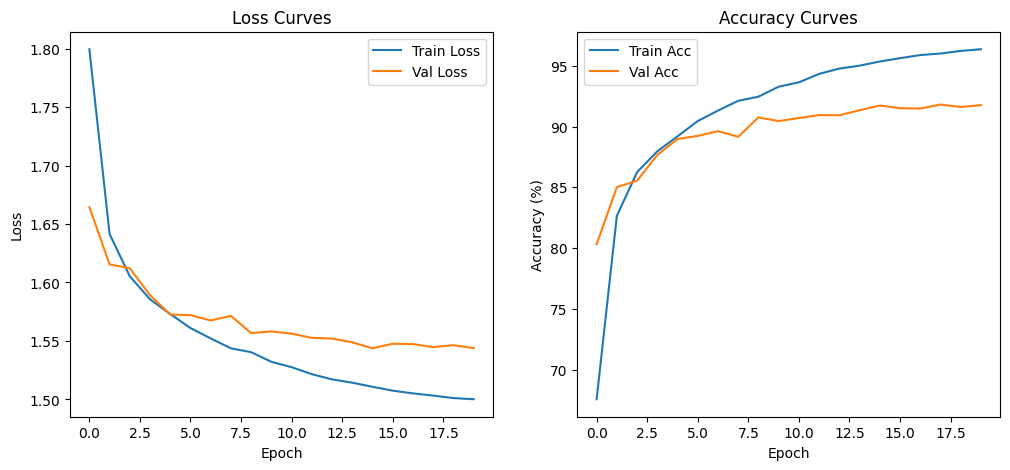

Mean Train Time: 270.012 seconds
Mean Validation Time: 61.278 seconds
VGG19 based model: Finished Training.


In [25]:
plot_acc_loss_cnn(train_losses, val_losses, train_accuracies, val_accuracies)
report_mean_train_val_time(train_times, val_times)

print('VGG19 based model: Finished Training.')

In [26]:
evaluate_model(cnn_model, testloader, "cnn")

Test Accuracy: 91.86%
